In [8]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

from unidip import UniDip
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

from clusterless import preprocess
from clusterless import viz
from clusterless import decoder


def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    '''
    https://matplotlib.org/stable/gallery/statistics/confidence_ellipse.html
    '''
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)


def plot_MoG_bounds(
    data, 
    labels, 
    labels_display, 
    np1_channel_map,
    channels=[], 
    local=False,
    plot_MoG=False,
    n_spikes=5_000, 
    figure_size=(8,16), 
    title='', 
):
    '''
    '''
    fig, axes = plt.subplots(1, 2, figsize=figure_size) 
    colors = [k for k,v in pltc.cnames.items()]
    random.shuffle(colors)
    for idx in labels_display:
        c = int(idx)
        if idx >= len(colors):
            c = c // 6  # only 148 colors available for plotting
            
        sub_data = data[labels == idx]
        x, z, maxptp = sub_data.T
        
        if len(sub_data) <= 2:
            continue
            
        if plot_MoG:
            confidence_ellipse(x, z, axes[0], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
            confidence_ellipse(maxptp, z, axes[1], alpha=1., edgecolor=colors[c], linewidth=1., zorder=0)
    
        if local:
            axes[0].scatter(x, z, s=.5, alpha=0.2, c=maxptp)
            axes[1].scatter(maxptp, z, s=.5, alpha=0.2, c=maxptp)
        else:
            axes[0].scatter(x[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            axes[1].scatter(maxptp[:n_spikes], z[:n_spikes], 
                            s=.5, alpha=0.05, c=maxptp[:n_spikes])
            
        if local:
            axes[0].set_xlim(x.min()-50, x.max()+50)
            axes[0].set_ylim(z.min()-100, z.max()+100)
            axes[1].set_xlim(0, maxptp.max()+30)
            axes[1].set_ylim(z.min()-100, z.max()+100)
        else:    
            axes[0].set_xlim(data[:,0].min()-10, data[:,0].max()+10)
            axes[0].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
            axes[1].set_xlim(data[:,2].min()-.5, data[:,2].max()+.5)
            axes[1].set_ylim(data[:,1].min()-10, data[:,1].max()+10)
        
    if len(channels) > 0: 
        for channel in channels:
            axes[0].plot(np1_channel_map[int(channel), 0], 
                         np1_channel_map[int(channel), 1], 
                         markersize=3, c='orange', marker="s")
                
    axes[0].set_xlabel('x (um)')
    axes[0].set_ylabel('z (um)')
    axes[0].set_title(f'{title}')
    axes[1].set_xlabel('log-ptp')
    axes[1].set_ylabel('z (um)')
    if plot_MoG:
        axes[1].set_title(f'n_units = {len(np.unique(labels_display))}')

    for ax in ['top','bottom','left','right']:
        axes[0].spines[ax].set_linewidth(1)
        axes[1].spines[ax].set_linewidth(1)

    plt.tight_layout()
    plt.show()

In [2]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016'

In [3]:
behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = preprocess.preprocess_static_behaviors(behave_dict)

choices left: 0.751, right: 0.249
stimuli left: 0.547, right: 0.453
reward wrong: 0.211, correct: 0.789


load data

In [4]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [5]:
n_trials = stim_on_times.shape[0]
n_channels = np1_channel_map.shape[0]

unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

In [6]:
# x, z, maxptp = spike_features.T
# logptp = np.log(maxptp+1) * x.std()
# spike_features = np.c_[x, z, logptp]

feature transformation

In [17]:
multi_modal_channels = {}
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
alpha = 0.1
for channel in np.unique(spike_channels):
    sub_spike_features = spike_features[spike_channels == channel]
    # a minimum of 2 points required for MoG
    if len(sub_spike_features) > 2: 
        pca = PCA(n_components=1, svd_solver='full')
        features_trans = pca.fit_transform(sub_spike_features).flatten()
        n_gaussians = len(UniDip(features_trans, alpha = alpha).run())
        if n_gaussians == 0:
            n_gaussians = 1
        if n_gaussians > 1:
            print(f'channel {channel} has {n_gaussians} modes ...')
            multi_modal_channels.update({channel: n_gaussians})
        if n_gaussians >= 1:
            sub_gmm = GaussianMixture(n_components=n_gaussians, 
                              max_iter=1000,
                              covariance_type='full',
                              init_params='kmeans', 
                              warm_start=False, 
                              verbose=0)
            sub_gmm.fit(sub_spike_features)
            sub_labels = sub_gmm.predict(sub_spike_features)
            sub_weights = [np.sum(sub_labels == i)/len(spike_features) for i in range(n_gaussians)]
            sub_weights_lst.append(sub_weights)
            sub_means_lst.append(sub_gmm.means_)
            sub_covs_lst.append(sub_gmm.covariances_)
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

channel 18.0 has 3 modes ...
channel 30.0 has 2 modes ...
channel 31.0 has 2 modes ...
channel 38.0 has 3 modes ...
channel 42.0 has 4 modes ...
channel 43.0 has 4 modes ...
channel 47.0 has 5 modes ...
channel 59.0 has 3 modes ...
channel 69.0 has 4 modes ...
channel 70.0 has 2 modes ...
channel 71.0 has 2 modes ...
channel 73.0 has 2 modes ...
channel 74.0 has 3 modes ...
channel 77.0 has 2 modes ...
channel 78.0 has 2 modes ...
channel 79.0 has 2 modes ...
channel 81.0 has 2 modes ...
channel 85.0 has 3 modes ...
channel 86.0 has 2 modes ...
channel 87.0 has 2 modes ...
channel 88.0 has 3 modes ...
channel 89.0 has 2 modes ...
channel 90.0 has 6 modes ...
channel 102.0 has 3 modes ...
channel 103.0 has 3 modes ...
channel 109.0 has 4 modes ...
channel 110.0 has 3 modes ...
channel 114.0 has 6 modes ...
channel 115.0 has 3 modes ...
channel 117.0 has 3 modes ...
channel 118.0 has 5 modes ...
channel 128.0 has 3 modes ...
channel 130.0 has 5 modes ...
channel 133.0 has 2 modes ...
cha

In [309]:
channel = 309
sub_spike_times = spike_times[spike_channels == channel]
sub_spike_features = spike_features[spike_channels == channel]
sub_x, sub_z, sub_maxptp = sub_spike_features.T

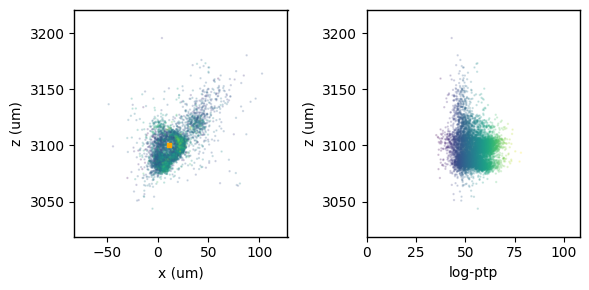

In [310]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_channels, 
    labels_display=[channel], 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=False,
    figure_size=(6,3)
)

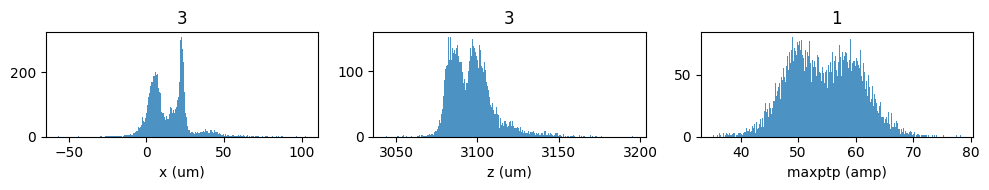

In [311]:
p_val = 0.05,
n_modes_x = len(UniDip(np.msort(sub_x), alpha=p_val).run())
n_modes_z = len(UniDip(np.msort(sub_z), alpha=p_val).run())
n_modes_ptp = len(UniDip(np.msort(sub_maxptp), alpha=p_val).run())
n_gaussians = np.max([n_modes_x, n_modes_z, n_modes_ptp])

fig, axes = plt.subplots(1,3, figsize=(10, 2))
axes[0].hist(sub_x, 300, alpha=.8)
axes[0].set_xlabel('x (um)')
axes[0].set_title(n_modes_x)
axes[1].hist(sub_z, 300, alpha=.8)
axes[1].set_xlabel('z (um)')
axes[1].set_title(n_modes_z)
axes[2].hist(sub_maxptp, 300, alpha=.8)
axes[2].set_xlabel('maxptp (amp)')
axes[2].set_title(n_modes_ptp)
plt.tight_layout()
plt.show()

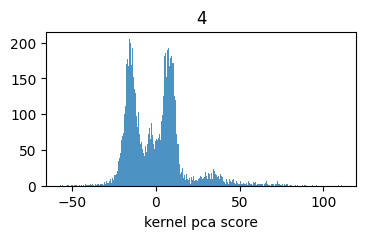

In [312]:
pca = PCA(n_components=1, svd_solver='full')
features_transformed = pca.fit_transform(sub_spike_features).flatten()

p_val = 0.05
n_tests = 1000
n_gaussians = len(UniDip(np.msort(features_transformed), alpha=p_val, ntrials=n_tests).run())
plt.figure(figsize=(4,2))
plt.hist(features_transformed, 300, alpha=.8)
plt.xlabel('kernel pca score')
plt.title(n_gaussians);

In [313]:
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='full',
                          init_params='kmeans', warm_start=False, verbose=0).fit(sub_spike_features)
sub_labels = sub_gmm.predict(sub_spike_features)

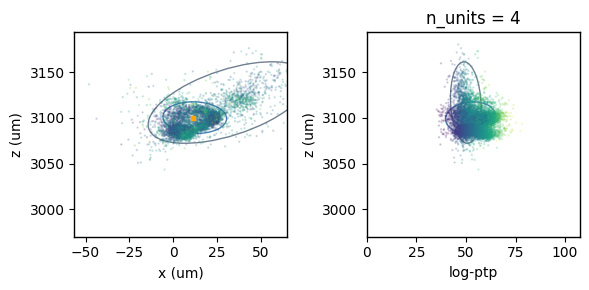

In [324]:
plot_MoG_bounds(
    data=sub_spike_features, 
    labels=sub_labels, 
    labels_display=np.unique(sub_labels), 
    np1_channel_map=np1_channel_map,
    channels=[channel], 
    local=True,
    plot_MoG=True,
    figure_size=(6,3),
    n_spikes = 1_000
)

In [18]:
post_split_gmm = GaussianMixture(n_components=len(sub_weights), 
                                 covariance_type='full')
post_split_gmm.weights_ = sub_weights
post_split_gmm.means_ = sub_means
post_split_gmm.covariances_ = sub_covs
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(sub_covs))

In [19]:
spike_labels = []
spike_probs = []
offset = 100_000
for i in range(8):
    print(f'loading batch {i+1} ..')
    spike_labels.extend(post_split_gmm.predict(spike_features[i*offset:(i+1)*offset]))
    spike_probs.extend(post_split_gmm.predict_proba(spike_features[i*offset:(i+1)*offset]))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

loading batch 1 ..
loading batch 2 ..
loading batch 3 ..
loading batch 4 ..
loading batch 5 ..
loading batch 6 ..
loading batch 7 ..
loading batch 8 ..


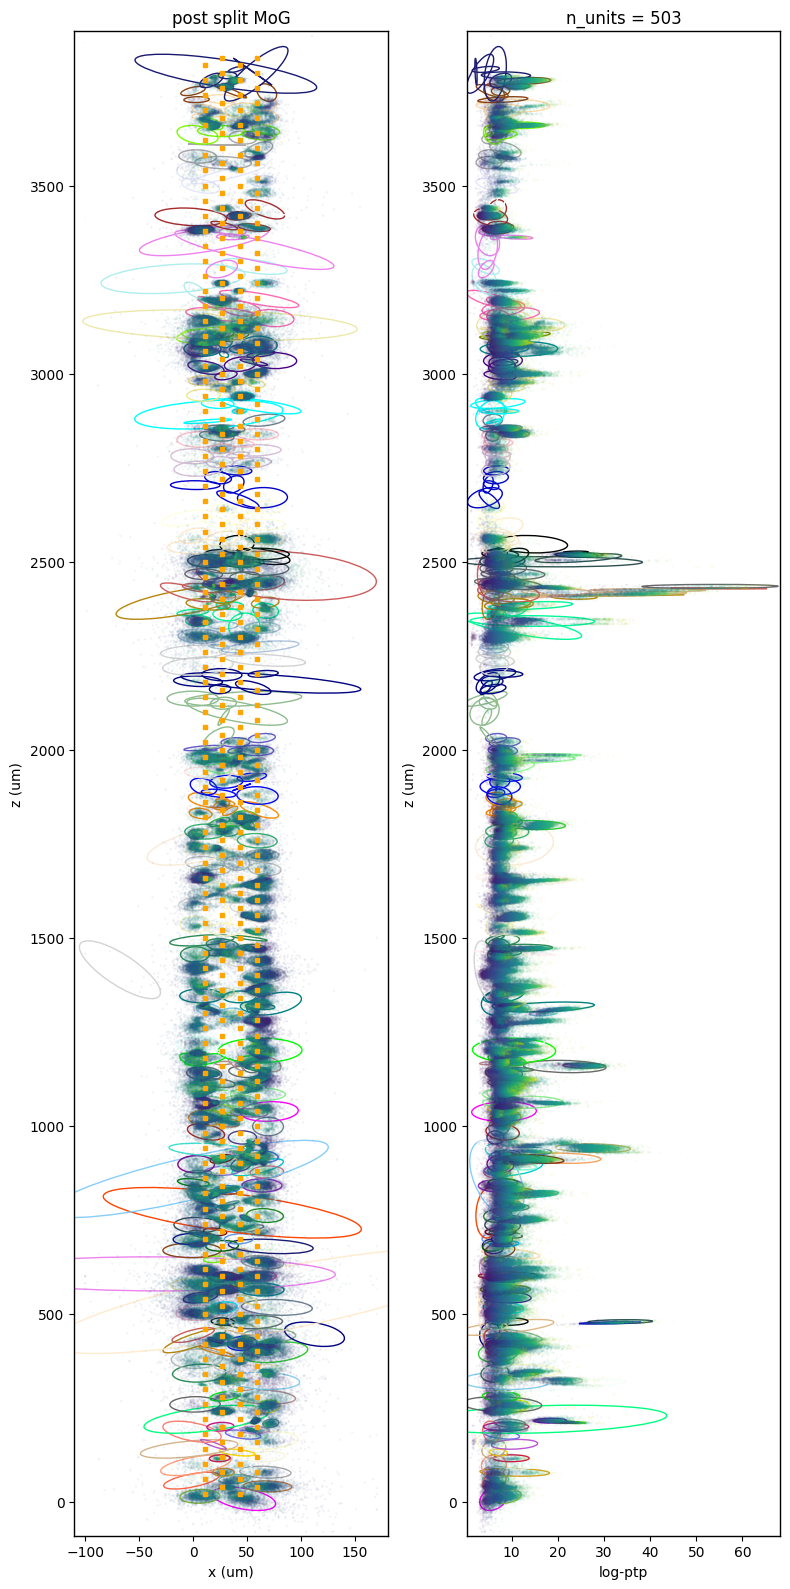

In [20]:
plot_MoG_bounds(
    data=spike_features, 
    labels=spike_labels, 
    labels_display=np.unique(spike_labels), 
    np1_channel_map=np1_channel_map,
    channels=np.arange(n_channels),
    plot_MoG=True,
    title='post split MoG'
)

In [21]:
clusterless_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    stim_on_times,
    'clusterless', 
    n_time_bins=30
)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')

clusterless neural data shape: (265, 503, 30)


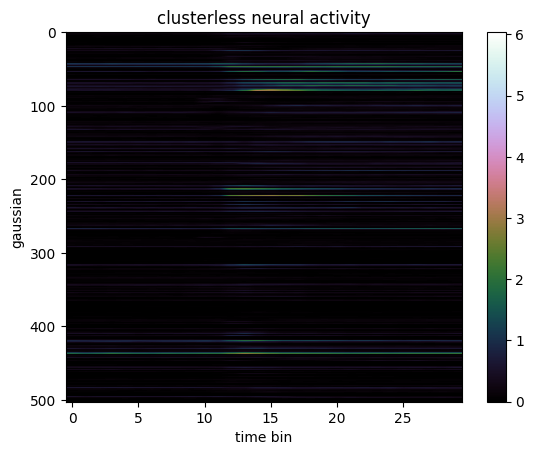

In [22]:
plt.imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
plt.title('clusterless neural activity')
plt.xlabel('time bin')
plt.ylabel('gaussian')
plt.colorbar();

In [23]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    choices, 
    behave_type='choice', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

choice fold 1 test accuracy: 0.887 auc: 0.952
choice fold 2 test accuracy: 0.943 auc: 0.973
choice fold 3 test accuracy: 0.925 auc: 0.969
choice fold 4 test accuracy: 0.906 auc: 0.981
choice fold 5 test accuracy: 0.925 auc: 0.985
choice mean of 5-fold cv accuracy: 0.917 auc: 0.972
choice sd of 5-fold cv accuracy: 0.019 auc: 0.012


In [24]:
cv_accs, cv_aucs, _, _, _, _ = decoder.cv_decode_static(
    clusterless_neural_data, 
    one_hot_stimuli, 
    behave_type='stimulus', 
    n_folds=5, 
    seed=seed, 
    shuffle=True
)

stimulus fold 1 test accuracy: 0.509 auc: 0.835
stimulus fold 2 test accuracy: 0.321 auc: 0.732
stimulus fold 3 test accuracy: 0.321 auc: 0.748
stimulus fold 4 test accuracy: 0.509 auc: 0.804
stimulus fold 5 test accuracy: 0.509 auc: 0.818
stimulus mean of 5-fold cv accuracy: 0.434 auc: 0.788
stimulus sd of 5-fold cv accuracy: 0.092 auc: 0.040


In [25]:
gmm_name = '../pretrained/danlab/Subjects/DY_016/init_max_chan_gmm'
np.save(gmm_name + '_weights', post_split_gmm.weights_, allow_pickle=False)
np.save(gmm_name + '_means', post_split_gmm.means_, allow_pickle=False)
np.save(gmm_name + '_covariances', post_split_gmm.covariances_, allow_pickle=False)